# Which Asset Class is safe against unexpected inflation?

This notebook attempts to duplicate this analysis by prof. Damodaran:

[Inflation and Investing: False Alarm or Fair Warning?](https://www.youtube.com/watch?v=p0vqmjgF3E4)

I thought it might be interesting to be able to get the latest data whenever we need to perform this analysis in the future.

Data source locations:

- Inflation: https://www.quandl.com/data/RATEINF/CPI_USA-Consumer-Price-Index-USA (need to sign up for an account to download)
- T-Bond: [Damodaran Online: Historical Returns on Stocks, Bonds and Bills](http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html) (I could not find a larger data source than the one in prof. Damodaran's website so I used it)
- Gold: [Gold Prices Dataset from Gold Hub](https://www.gold.org/goldhub/data/gold-prices) (need to sign up for an account to download)
- S&P 500 and Real Estate: [ONLINE DATA ROBERT SHILLER](http://www.econ.yale.edu/~shiller/data.htm) (Much thanks to Prof. Robert J. Shiller for providing this dataset)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd, YearEnd, YearBegin
from IPython.display import display
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from styles import style as style_df, format_row_wise, round_or_null, percent_or_null

INFLATION_DATA = 'data/inflation.csv'
TBOND_DATA = 'data/histretSP.xls'
SP500_DATA = 'data/sp500.xls'
GOLD_DATA = 'data/gold.xlsx'
REAL_ESTATE_DATA = 'data/real_estate.xls'

## 1. Prepare Expected and Unexpected Inflation Rates

In [2]:
inf = pd.read_csv(INFLATION_DATA)

### Assess

In [3]:
display(inf)
inf.info()

,Date,Value
0,2021-05-31,4.993
1,2021-04-30,4.160
2,2021-03-31,2.620
3,2021-02-28,1.676
4,2021-01-31,1.400
...,...,...
1284,1914-05-31,2.062
1285,1914-04-30,0.000
1286,1914-03-31,1.020
1287,1914-02-28,1.020


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1289 non-null   object 
 1   Value   1289 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.3+ KB


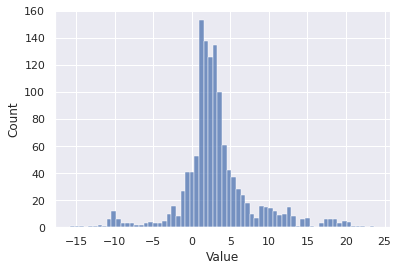

In [4]:
sns.set_theme()
sns.histplot(data=inf, x="Value");

### Clean

In [5]:
inf = inf.rename(columns={'Date': 'date', 'Value': 'value'})
inf['date'] = pd.to_datetime(inf['date'])
inf.set_index('date', inplace=True)
inf['value'] = inf['value'] / 100
inf = inf.groupby(pd.Grouper(freq="Y")).value.mean().to_frame(name='actual_inflation')

### Test

In [6]:
inf.info()
display(inf)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 1914-12-31 to 2021-12-31
Freq: A-DEC
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   actual_inflation  108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


,actual_inflation
date,
1914-12-31,0.013494
1915-12-31,0.009234
1916-12-31,0.076426
1917-12-31,0.178002
1918-12-31,0.172546
...,...
2017-12-31,0.021301
2018-12-31,0.024428
2019-12-31,0.018117


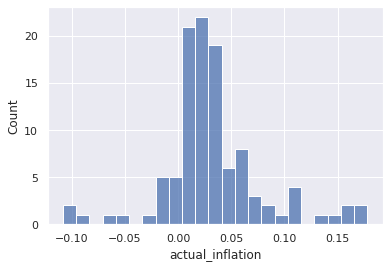

In [7]:
sns.set_theme()
sns.histplot(data=inf, x="actual_inflation");

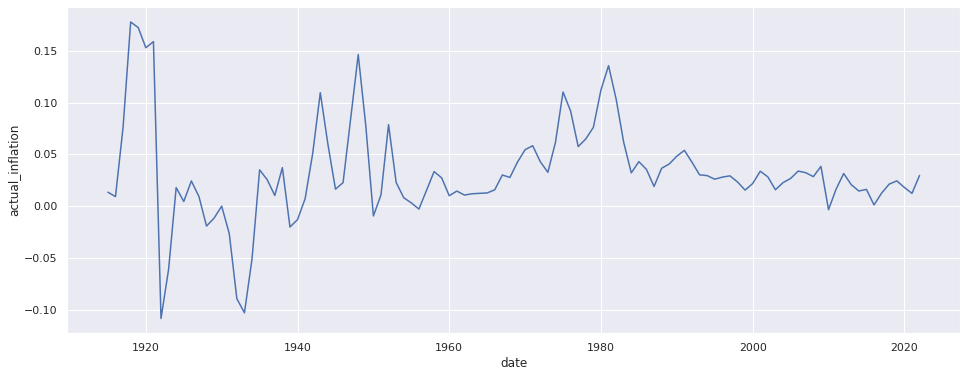

In [8]:
plt.figure(figsize=(16, 6))
sns.set_theme()
sns.lineplot(data=inf, x=inf.index, y="actual_inflation");

In [9]:
inf = inf.sort_values(by='date')
inf['avg_past_10y'] = inf['actual_inflation'].rolling(10).mean()
inf['unexpected_inflation'] = inf['actual_inflation'] - inf['avg_past_10y']
inf[:12]

,actual_inflation,avg_past_10y,unexpected_inflation
date,,,
1914-12-31,0.013494,NaN,NaN
1915-12-31,0.009234,NaN,NaN
1916-12-31,0.076426,NaN,NaN
1917-12-31,0.178002,NaN,NaN
1918-12-31,0.172546,NaN,NaN
1919-12-31,0.153107,NaN,NaN
1920-12-31,0.158990,NaN,NaN
1921-12-31,-0.108520,NaN,NaN
1922-12-31,-0.061018,NaN,NaN


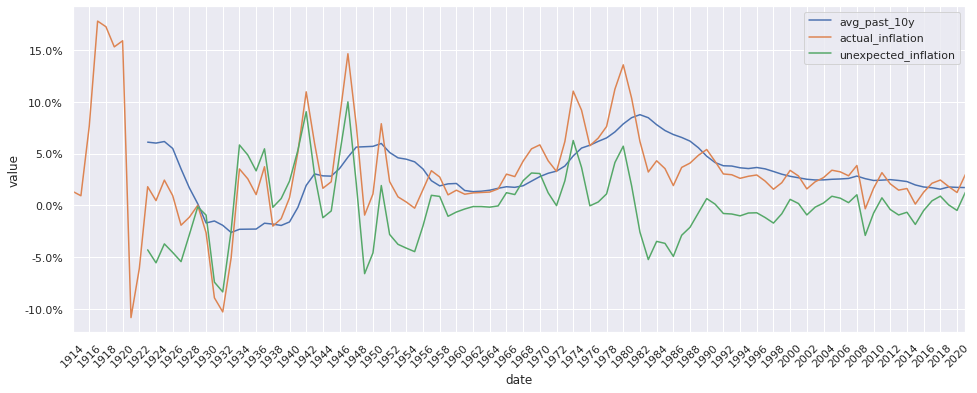

In [10]:
def plot_multilines(df, x, Y):
    df_plot = df.reset_index()[[x]+Y]
    if pd.api.types.is_datetime64_ns_dtype(df_plot[x].dtype):
        df_plot[x] = df_plot[x] - YearBegin(1)
    df_plot = df_plot.melt(x, var_name='cols', value_name='vals')
    plt.figure(figsize=(16, 6))
    sns.set_theme()
    ax = sns.lineplot(x=x, y='vals', hue='cols', data=df_plot)
    return ax


def style(ax, labels=None, year_gap=2):
    ax.xaxis.set_major_locator(mdates.YearLocator(year_gap))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.margins(x=0)
    ax.set(ylabel="value")
    ax.legend(title="")
    if labels != None:
        legend = ax.legend()
        for i, l in enumerate(labels):
            legend.texts[i].set_text(l)
    return plt.xticks(rotation=45)

ax = plot_multilines(inf, 'date', ['avg_past_10y', 'actual_inflation', 'unexpected_inflation'])
ax = style(ax);

## 2. 10-year US T-Bond and 3-month US T-Bill

In [11]:
tbond = pd.read_excel(TBOND_DATA,
                      sheet_name="Returns by year",
                      skiprows=list(range(0,17)))
tbond = tbond[['Year', 'US T. Bond', '3-month T.Bill']]
tbond = tbond.rename(columns={'Year': 'date', 'US T. Bond': 'tbond', '3-month T.Bill': 'tbill'})
eof_id = tbond[tbond['date'] == 'Arithmetic Average Historical Return'].index[0]
tbond = tbond.iloc[0:eof_id].dropna()
tbond['date'] = pd.to_datetime(tbond['date'], format='%Y') + YearEnd(1)
tbond = tbond.set_index('date')

In [12]:
combined1 = pd.merge(inf, tbond, left_on='date', right_on='date', how='left')
combined1 = combined1[['actual_inflation', 'unexpected_inflation', 'tbond', 'tbill']]

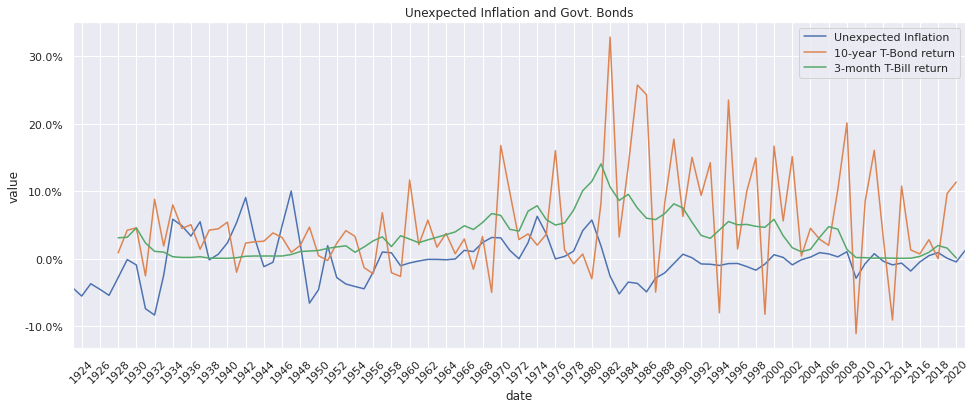

In [13]:
ax = plot_multilines(combined1, 'date', ['unexpected_inflation', 'tbond', 'tbill'])
style(ax, ["Unexpected Inflation", "10-year T-Bond return", "3-month T-Bill return"])
ax.set_title("Unexpected Inflation and Govt. Bonds");

## 3. S&P 500 Index

In [14]:
sp500 = pd.read_excel(SP500_DATA,
                      sheet_name="Data",
                      skiprows=list(range(0,7))
                      )
sp500 = sp500.iloc[:-1, :3]
sp500 = sp500.rename(columns={'Date': 'date', 'P': 'price', 'D': 'dividend'})

# 1871.1 to 1871.10
sp500['date'] = sp500['date'].apply(lambda x: '{0:.2f}'.format(x))

sp500['date'] = sp500['date'].astype(str)
sp500['price'] = sp500['price'].astype(float)
sp500['date'] = pd.to_datetime(sp500['date'], format="%Y.%m")
sp500['date'] = sp500['date'] + MonthEnd(1)
sp500.set_index('date', inplace=True)

In [15]:
def get_earnings_plus_dividends_yoy(df):
    g = df.groupby(pd.Grouper(freq="Y"))
    dividend = g.dividend.mean()
    firstp = g.price.last().shift(1)
    lastp = g.price.last()
    lastp_div = lastp + dividend
    comb = firstp.to_frame(name='first') \
           .join(lastp.to_frame(name='last')) \
           .join(dividend.to_frame(name='dividend')) \
           .join(lastp_div.to_frame(name='last_plus_dividend'))
    comb['yoy_change'] = (comb['last_plus_dividend'] / comb['first']) - 1
    return comb
sp500g = get_earnings_plus_dividends_yoy(sp500)
sp500g = sp500g[sp500g.index.year >= inf.index[0].year]
sp500g

,first,last,dividend,last_plus_dividend,yoy_change
date,,,,,
1914-12-31,8.040000,7.350000,0.447500,7.797500,-0.030162
1915-12-31,7.350000,9.480000,0.425417,9.905417,0.347676
1916-12-31,9.480000,9.800000,0.500417,10.300417,0.086542
1917-12-31,9.800000,6.800000,0.630417,7.430417,-0.241794
1918-12-31,6.800000,7.900000,0.625000,8.525000,0.253676
...,...,...,...,...,...
2017-12-31,2246.630000,2664.340000,47.405833,2711.745833,0.207028
2018-12-31,2664.340000,2567.310000,51.368333,2618.678333,-0.017138
2019-12-31,2567.310000,3176.749524,56.245152,3232.994676,0.259293


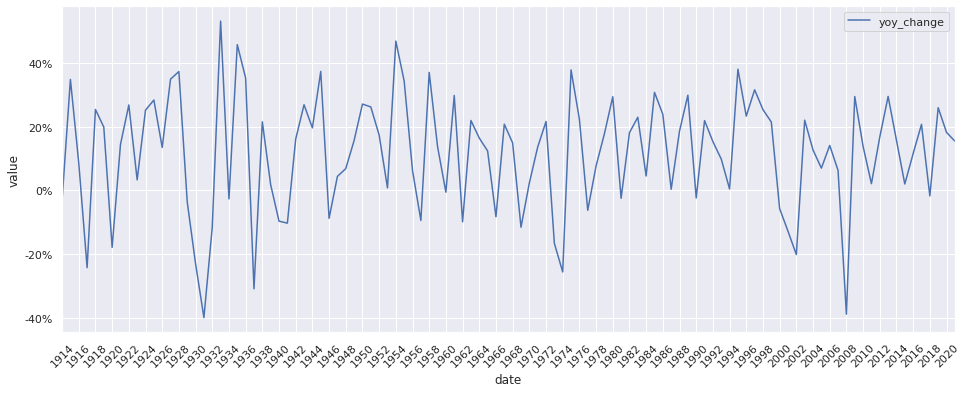

In [16]:
ax = plot_multilines(sp500g, 'date', ['yoy_change'])
style(ax);

### Merging unexpected inflation + S&P 500 Index

In [17]:
combined2 = pd.merge(combined1, sp500g, left_on='date', right_on='date', how='left')
combined2 = combined2.rename(columns={'yoy_change': 'sp500'})
combined2 = combined2[['actual_inflation', 'unexpected_inflation', 'tbond', 'tbill', 'sp500']]

In [18]:
combined2

,actual_inflation,unexpected_inflation,tbond,tbill,sp500
date,,,,,
1914-12-31,0.013494,NaN,NaN,NaN,-0.030162
1915-12-31,0.009234,NaN,NaN,NaN,0.347676
1916-12-31,0.076426,NaN,NaN,NaN,0.086542
1917-12-31,0.178002,NaN,NaN,NaN,-0.241794
1918-12-31,0.172546,NaN,NaN,NaN,0.253676
...,...,...,...,...,...
2017-12-31,0.021301,0.004320,0.028017,0.009308,0.207028
2018-12-31,0.024428,0.008850,-0.000167,0.019392,-0.017138
2019-12-31,0.018117,0.000389,0.096356,0.015500,0.259293


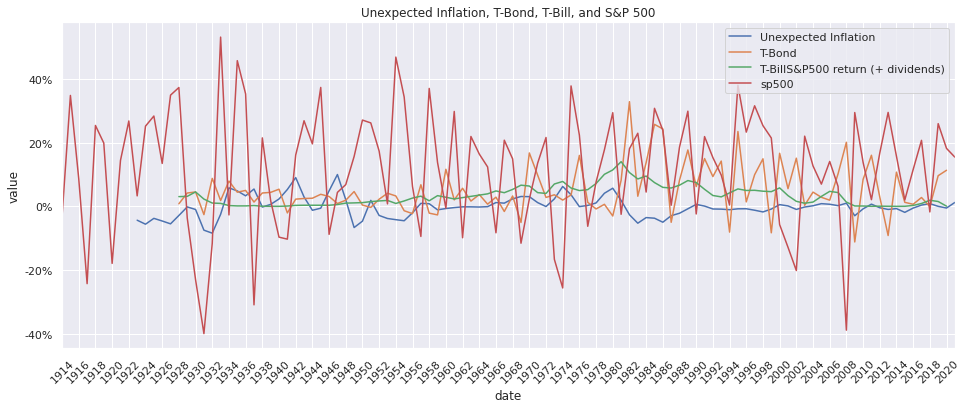

In [19]:
ax = plot_multilines(combined2, 'date', ['unexpected_inflation', 'tbond', 'tbill', 'sp500'])
style(ax, ["Unexpected Inflation", "T-Bond", "T-Bill" "S&P500 return (+ dividends)"])
ax.set_title("Unexpected Inflation, T-Bond, T-Bill, and S&P 500");

## 4. Gold

In [20]:
gold = pd.read_excel(GOLD_DATA,
                     sheet_name="Annual_EndofPeriod",
                     skiprows=list(range(0,9)),
                     header=None,
                     engine="openpyxl")
gold = gold.iloc[:, 3:5]
gold = gold.rename(columns={3: 'date', 4: 'price'})
gold['date'] = pd.to_datetime(gold['date'], format='%Y') + YearEnd(1)
gold = gold.set_index('date')
gold['firstp'] = gold['price'].shift(1)
gold['yoy_change'] = (gold['price'] / gold['firstp']) - 1

In [21]:
gold.head(5)

,price,firstp,yoy_change
date,,,
1978-12-31,226.00,NaN,NaN
1979-12-31,512.00,226.00,1.265487
1980-12-31,589.75,512.00,0.151855
1981-12-31,397.50,589.75,-0.325986
1982-12-31,456.90,397.50,0.149434


In [22]:
combined3 = pd.merge(combined2, gold, left_on='date', right_on='date', how='left')
combined3 = combined3.rename(columns={'yoy_change': 'gold'})
combined3 = combined3[['actual_inflation', 'unexpected_inflation', 'tbond', 'tbill', 'sp500', 'gold']]

In [23]:
combined3

,actual_inflation,unexpected_inflation,tbond,tbill,sp500,gold
date,,,,,,
1914-12-31,0.013494,NaN,NaN,NaN,-0.030162,NaN
1915-12-31,0.009234,NaN,NaN,NaN,0.347676,NaN
1916-12-31,0.076426,NaN,NaN,NaN,0.086542,NaN
1917-12-31,0.178002,NaN,NaN,NaN,-0.241794,NaN
1918-12-31,0.172546,NaN,NaN,NaN,0.253676,NaN
...,...,...,...,...,...,...
2017-12-31,0.021301,0.004320,0.028017,0.009308,0.207028,0.126625
2018-12-31,0.024428,0.008850,-0.000167,0.019392,-0.017138,-0.009295
2019-12-31,0.018117,0.000389,0.096356,0.015500,0.259293,0.184324


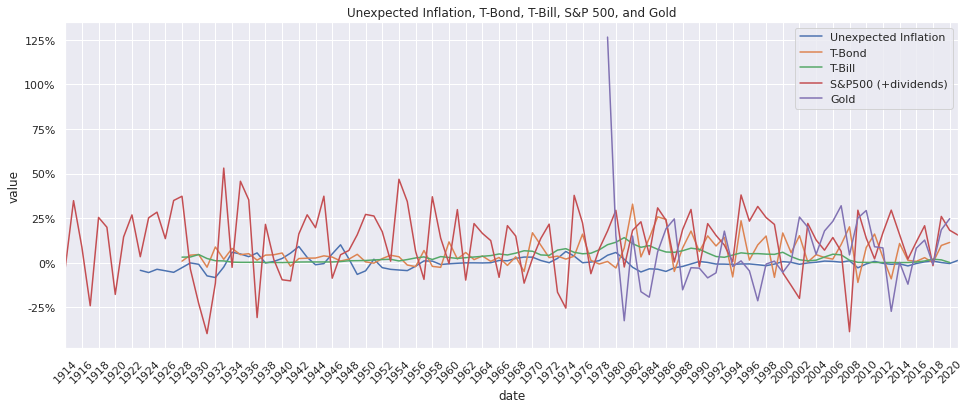

In [24]:
ax = plot_multilines(combined3, 'date', ['unexpected_inflation', 'tbond', 'tbill', 'sp500', 'gold'])
style(ax, ["Unexpected Inflation", "T-Bond", "T-Bill", "S&P500 (+dividends)", "Gold"])
ax.set_title("Unexpected Inflation, T-Bond, T-Bill, S&P 500, and Gold");

## 5. Real Estate

In [25]:
real_estate = pd.read_excel(REAL_ESTATE_DATA,
                            sheet_name="Data",
                            skiprows=list(range(0,6)),
                            engine="xlrd")
real_estate = real_estate.rename(columns={'Date': 'year', 'From fig2.1Revised2011.xls': 'index'})
real_estate = real_estate[['year', 'index']]
real_estate = real_estate.dropna()

def impute_values(df, id_field, value_field):
    """ Impute missing values in `df` by looking at id differences.
    
    
    """
    # Create rows with values for missing years set to None
    indices = pd.Index(np.arange(df[id_field].min(), df[id_field].max(), 1))
    df1 = df.set_index(id_field)
    missing_indices = indices.difference(df1.index)
    for idx in missing_indices:
        df1.loc[idx, value_field] = None
    
    # Interpolate None values
    df1 = df1.sort_index()
    df1[value_field] = df1[value_field].interpolate(method='linear')
    
    # Remove non-whole values
    df1 = df1.loc[df1.index % 1 == 0]
    
    # Reduce years by 1
    df1 = df1.reset_index()
    df1.loc[df1.year.isin(missing_indices), 'year'] -= 1
    df1 = df1.set_index('year')
    return df1

real_estate = impute_values(real_estate, 'year', 'index')

real_estate['date'] = pd.to_datetime(real_estate.index.astype(int), format="%Y") + YearEnd(1)
real_estate = real_estate.set_index('date')
real_estate['prev_index'] = real_estate['index'].shift(1)
real_estate['yoy_change'] = real_estate['index'] / real_estate['prev_index'] - 1
real_estate = real_estate.dropna()
real_estate['yoy_change'] = real_estate['yoy_change'].astype(float)
real_estate

,index,prev_index,yoy_change
date,,,
1891-12-31,3.209111,3.557296,-0.097879
1892-12-31,3.267142,3.209111,0.018083
1893-12-31,3.406416,3.267142,0.042629
1894-12-31,3.969316,3.406416,0.165247
1895-12-31,3.603721,3.969316,-0.092105
...,...,...,...
2016-12-31,184.580000,175.110000,0.054080
2017-12-31,196.045000,184.580000,0.062114
2018-12-31,204.545000,196.045000,0.043357


### Understanding how Interpolation works

,index
year,
1956.875,14.608379
1956.958,14.624941
1957.000,NaN
1957.042,14.674630
1957.125,14.807132


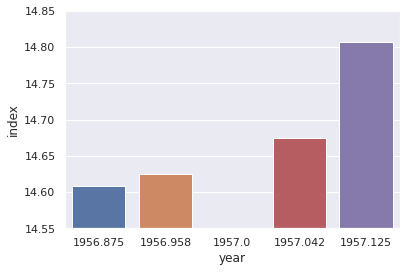

In [26]:
df = pd.read_excel(REAL_ESTATE_DATA,
                   sheet_name="Data",
                   skiprows=list(range(0,6)),
                   engine="xlrd")
df = df.rename(columns={'Date': 'year', 'From fig2.1Revised2011.xls': 'index'})
df = df[['year', 'index']]
df = df.dropna()
df = df.iloc[109:113]
df['year'] = df['year'].round(3)
df = df.set_index('year')
df.loc[1957.0, 'index'] = None
df = df.sort_index()
ax = sns.barplot(data=df, x=df.index, y='index')
ax.set(ylim=(14.55, 14.85));
display(df)

,index
year,
1956.875,14.608379
1956.958,14.624941
1957.000,14.649786
1957.042,14.674630
1957.125,14.807132


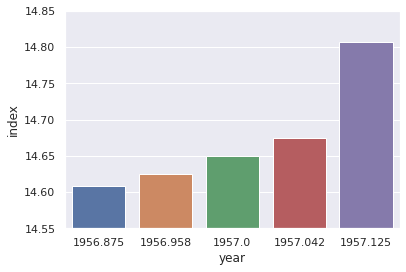

In [27]:
df['index'] = df['index'].interpolate(method='linear')
ax = sns.barplot(data=df, x=df.index, y='index')
ax.set(ylim=(14.55, 14.85));
display(df)

### Back to preparing real estate data

In [28]:
combined4 = pd.merge(combined3, real_estate, left_on='date', right_on='date')
combined4 = combined4.rename(columns={'yoy_change': 'real_estate'})
combined4 = combined4[['actual_inflation', 'unexpected_inflation', 'tbond', 'tbill', 'sp500', 'gold', 'real_estate']]

In [29]:
combined4

,actual_inflation,unexpected_inflation,tbond,tbill,sp500,gold,real_estate
date,,,,,,,
1914-12-31,0.013494,NaN,NaN,NaN,-0.030162,NaN,0.037185
1915-12-31,0.009234,NaN,NaN,NaN,0.347676,NaN,-0.081946
1916-12-31,0.076426,NaN,NaN,NaN,0.086542,NaN,0.094840
1917-12-31,0.178002,NaN,NaN,NaN,-0.241794,NaN,0.020382
1918-12-31,0.172546,NaN,NaN,NaN,0.253676,NaN,0.063670
...,...,...,...,...,...,...,...
2016-12-31,0.012636,-0.005067,0.006906,0.003175,0.115441,0.081038,0.054080
2017-12-31,0.021301,0.004320,0.028017,0.009308,0.207028,0.126625,0.062114
2018-12-31,0.024428,0.008850,-0.000167,0.019392,-0.017138,-0.009295,0.043357


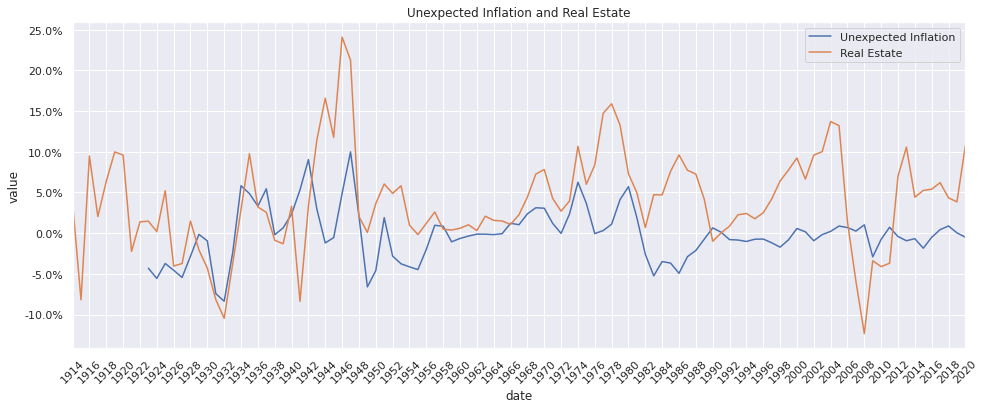

In [30]:
ax = plot_multilines(combined4, 'date', ['unexpected_inflation', 'real_estate'])
style(ax, ["Unexpected Inflation", "Real Estate"])
ax.set_title("Unexpected Inflation and Real Estate");

## 6. Returns throughout the decades

In [31]:
decades = combined4[combined4.index.year >= 1920].groupby(pd.Grouper(freq="10Y")).mean()
decades['start_year'] = (decades.index - YearBegin(10)).year.astype(str)
decades['end_year'] = decades.index.year.astype(str)
decades['period'] = decades['start_year'].str.cat(decades['end_year'], sep='-')
decades = decades.set_index('period')
decades = decades.drop(columns=['start_year', 'end_year'])
decades

,actual_inflation,unexpected_inflation,tbond,tbill,sp500,gold,real_estate
period,,,,,,,
1911-1920,0.158990,NaN,NaN,NaN,-0.178345,NaN,0.096051
1921-1930,-0.017063,-0.034405,0.031934,0.035967,0.157005,NaN,-0.006599
1931-1940,-0.016091,0.004009,0.040947,0.005381,0.062776,NaN,-0.002843
1941-1950,0.056967,0.021363,0.020237,0.005956,0.134792,NaN,0.085910
1951-1960,0.021259,-0.016354,0.019794,0.021281,0.172544,NaN,0.025226
1961-1970,0.027728,0.009988,0.030228,0.043348,0.088862,NaN,0.029365
1971-1980,0.078629,0.024685,0.036036,0.067977,0.101721,0.708671,0.087236
1981-1990,0.047446,-0.023162,0.135136,0.084278,0.144081,-0.025060,0.050491
1991-2000,0.028032,-0.007148,0.088711,0.046839,0.181311,-0.029219,0.037467


In [32]:
tpl = {
    'actual_inflation': ("Actual Inflation", lambda x: f"{percent_or_null(x)}"),
    'unexpected_inflation': ("Unexpected Inflation", lambda x: f"{percent_or_null(x)}"),
    'tbond': ("10-year T-Bond", lambda x: f"{percent_or_null(x)}"),
    'tbill': ("3-month T-Bill", lambda x: f"{percent_or_null(x)}"),
    'sp500': ("S&P 500 + dividend", lambda x: f"{percent_or_null(x)}"),
    'gold': ("Gold", lambda x: f"{percent_or_null(x)}"),
    'real_estate': ("Real Estate", lambda x: f"{percent_or_null(x)}"),
}

def highlight(data, color='#DCDCDC'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}; font-weight: bold;'.format(color)
    return attr

display(style_df(decades, tpl, key='col').applymap(highlight, subset=pd.IndexSlice[:, ['Unexpected Inflation']]))

,Actual Inflation,Unexpected Inflation,10-year T-Bond,3-month T-Bill,S&P 500 + dividend,Gold,Real Estate
period,,,,,,,
1911-1920,15.90%,None,None,None,-17.83%,None,9.61%
1921-1930,-1.71%,-3.44%,3.19%,3.60%,15.70%,None,-0.66%
1931-1940,-1.61%,0.40%,4.09%,0.54%,6.28%,None,-0.28%
1941-1950,5.70%,2.14%,2.02%,0.60%,13.48%,None,8.59%
1951-1960,2.13%,-1.64%,1.98%,2.13%,17.25%,None,2.52%
1961-1970,2.77%,1.00%,3.02%,4.33%,8.89%,None,2.94%
1971-1980,7.86%,2.47%,3.60%,6.80%,10.17%,70.87%,8.72%
1981-1990,4.74%,-2.32%,13.51%,8.43%,14.41%,-2.51%,5.05%
1991-2000,2.80%,-0.71%,8.87%,4.68%,18.13%,-2.92%,3.75%


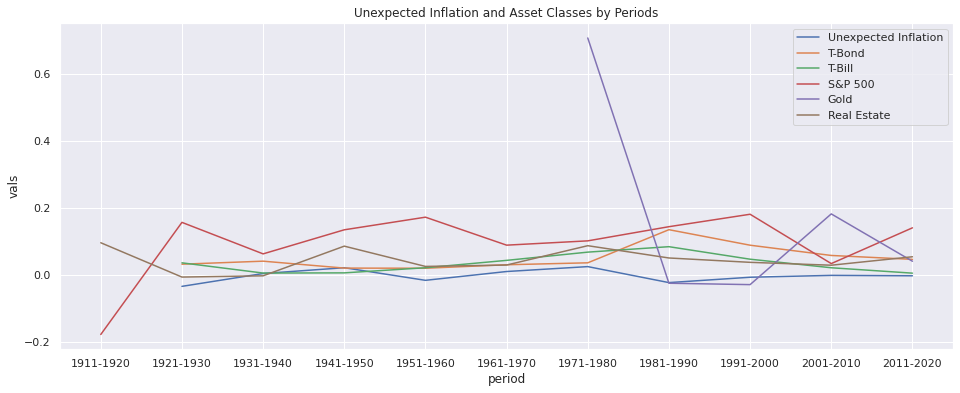

In [33]:
ax = plot_multilines(decades, 'period', ['unexpected_inflation', 'tbond', 'tbill', 'sp500', 'gold', 'real_estate'])
labels = ["Unexpected Inflation", "T-Bond", "T-Bill", "S&P 500", "Gold", "Real Estate"]
legend = ax.legend()
for i, l in enumerate(labels):
    legend.texts[i].set_text(l)
ax.set_title("Unexpected Inflation and Asset Classes by Periods");

## 7. Correlation Analysis

In [34]:
corr = combined4[['actual_inflation', 'unexpected_inflation', 'tbond', 'tbill', 'sp500', 'gold', 'real_estate']].corr()
corr

,actual_inflation,unexpected_inflation,tbond,tbill,sp500,gold,real_estate
actual_inflation,1.000000,0.722838,0.036832,0.445319,-0.109166,0.241603,0.493640
unexpected_inflation,0.722838,1.000000,-0.132218,-0.000787,-0.180496,0.332640,0.363803
tbond,0.036832,-0.132218,1.000000,0.264140,-0.014174,-0.059320,-0.079749
tbill,0.445319,-0.000787,0.264140,1.000000,-0.042112,-0.026387,0.111351
sp500,-0.109166,-0.180496,-0.014174,-0.042112,1.000000,0.014009,0.086949
gold,0.241603,0.332640,-0.059320,-0.026387,0.014009,1.000000,0.128492
real_estate,0.493640,0.363803,-0.079749,0.111351,0.086949,0.128492,1.000000


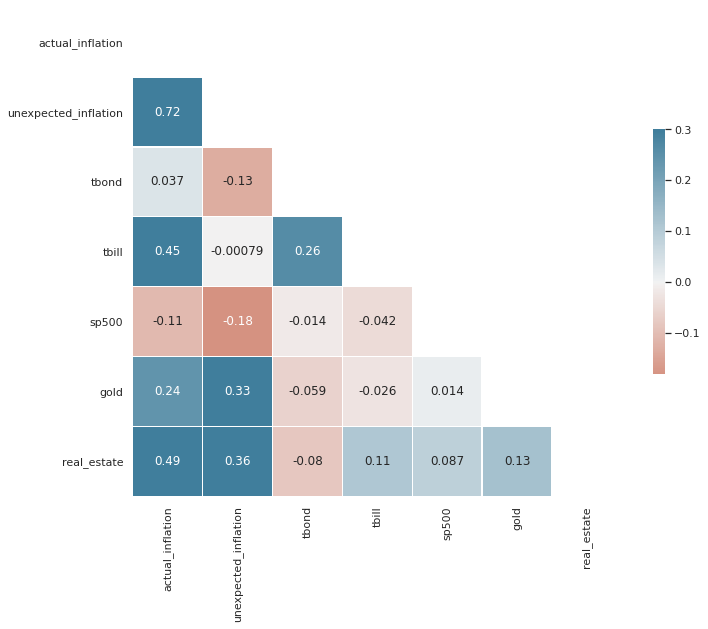

In [35]:
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(20, 230, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True);

### Conclusions

1. Gold and Real estate are a good hedge for inflation.
2. Real estate performed better than gold in an environment with high actual inflation rate.